In [44]:
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [45]:
import numpy as np
import pandas as pd
import datetime as dt
from datetime import datetime

# Reflect Tables into SQLAlchemy ORM

In [46]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, desc, and_

In [47]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [48]:
# reflect an existing database into a new model
Base = automap_base()

# reflect the tables
Base.prepare(autoload_with=engine)

In [49]:
# View all of the classes that automap found
Base.classes.keys()

['station', 'measurement']

In [50]:
# Save references to each table
station = Base.classes.station
measurement = Base.classes.measurement

In [51]:
# Create our session (link) from Python to the DB
session = Session(bind=engine)

# Exploratory Precipitation Analysis

In [52]:
# Find the most recent date in the data set.
session.query(measurement).order_by(desc(measurement.date)).first().date

'2017-08-23'

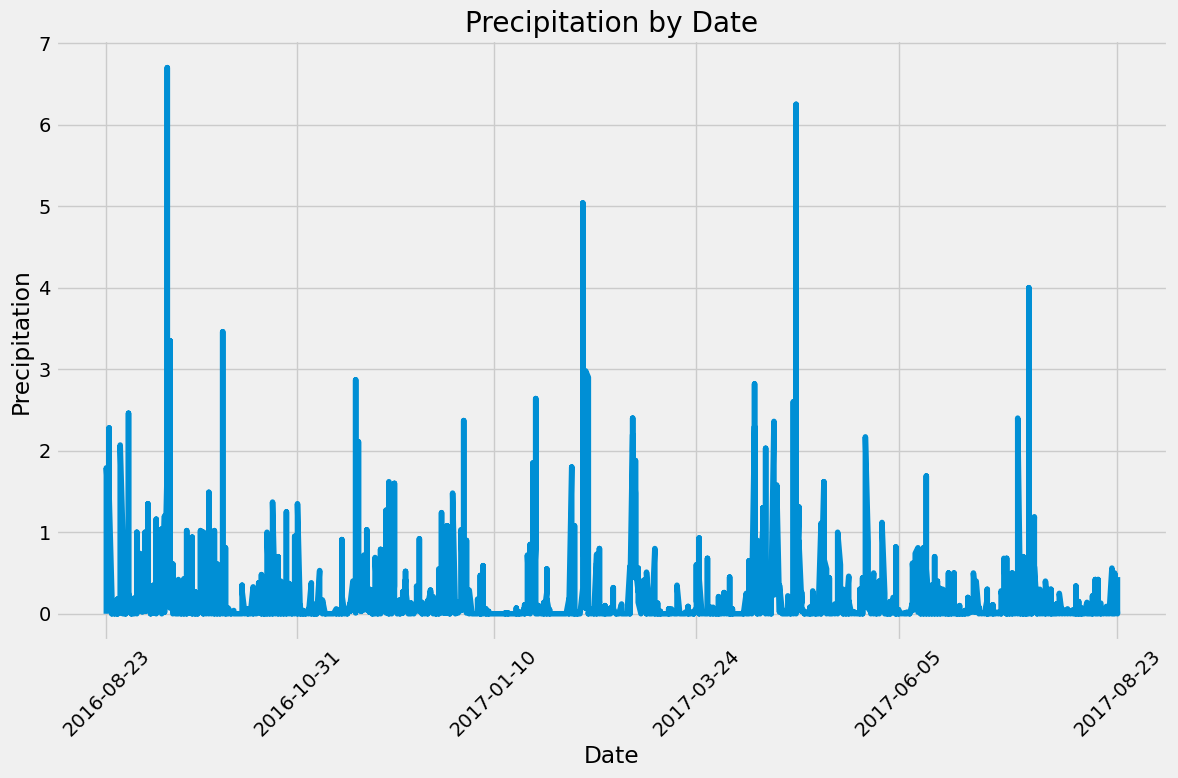

In [53]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 
latest = session.query(measurement).order_by(desc(measurement.date)).first().date
# Calculate the date one year from the last date in data set.
year_ago = datetime.strptime(latest, "%Y-%m-%d") - dt.timedelta(days=365)

# Perform a query to retrieve the data and precipitation scores
year_ago_data = session.query(measurement.date, measurement.prcp).filter(measurement.date >= year_ago.strftime("%Y-%m-%d")).statement
# Save the query results as a Pandas DataFrame. Explicitly set the column names
df_2016 = pd.read_sql_query(year_ago_data, engine).rename(columns={'date':'date', 'prcp':'precipitation'}).dropna()

# Sort the dataframe by date
df_2016.sort_values(by='date', inplace=True)

# Use Pandas Plotting with Matplotlib to plot the data
dates = df_2016['date']
values = df_2016['precipitation']

plt.figure(figsize=(12,8))
plt.plot(dates, values)
tick_indices = range(0, len(dates), len(dates) // 5)
plt.xticks(ticks=dates.iloc[tick_indices], labels=dates.iloc[tick_indices], rotation = 45)
plt.xlabel('Date')
plt.ylabel('Precipitation')
plt.title('Precipitation by Date')
plt.tight_layout()
plt.show()

In [54]:
# Use Pandas to calculate the summary statistics for the precipitation data
df_2016.describe()

,precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [55]:
# Design a query to calculate the total number of stations in the dataset
session.query(func.count(station.station)).scalar()

9

In [56]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
counts = session.query(measurement.station, 
                       func.count(measurement.station).label('count')
                       ).group_by(measurement.station).order_by(func.count(measurement.station).desc()).all()
counts

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [57]:
results = session.query(
    func.max(measurement.tobs).label('max'),
    func.min(measurement.tobs).label('min'),
    func.avg(measurement.tobs.label('avg'))
).filter(measurement.station == counts[0][0]).one()
results

(85.0, 54.0, 71.66378066378067)

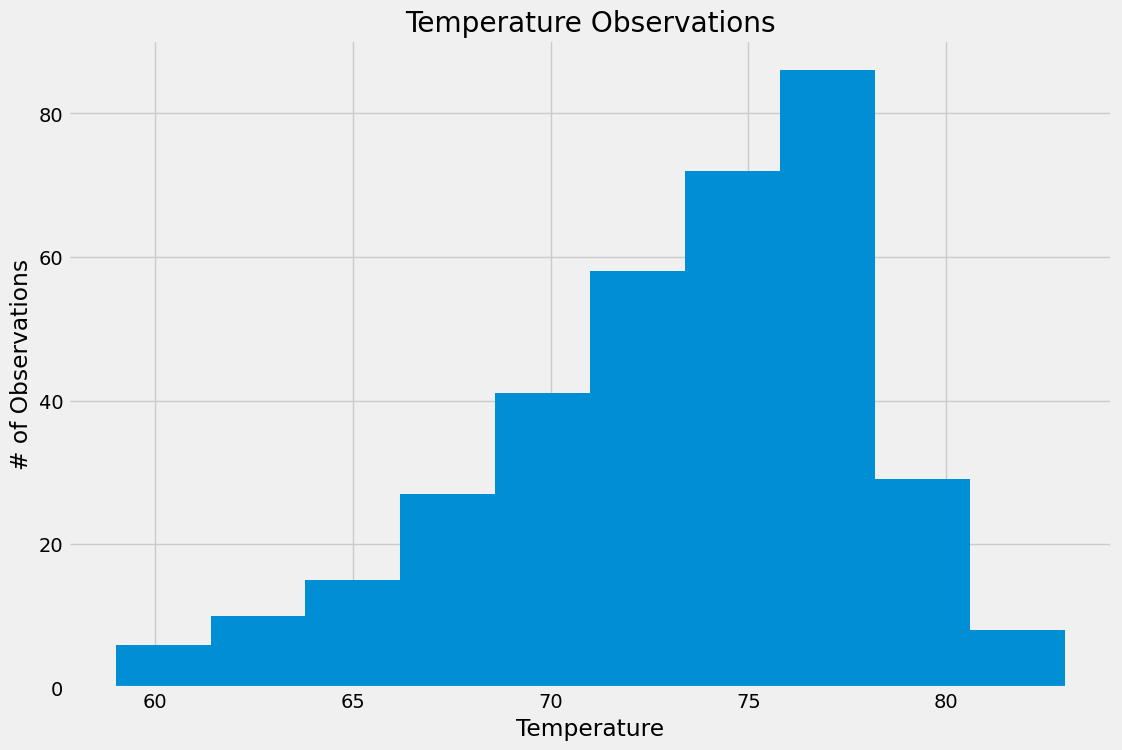

In [58]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
year_ago_top_station = session.query(measurement.tobs).filter(
    and_(
        measurement.date >= year_ago.strftime("%Y-%m-%d"),
        measurement.station == counts[0][0])
).statement
df_top_station = pd.read_sql_query(year_ago_top_station, engine).dropna()

temps = df_top_station['tobs']

plt.figure(figsize=(12,8))
plt.hist(temps)

plt.xlabel('Temperature')
plt.ylabel('# of Observations')
plt.title('Temperature Observations')

plt.show()

# Close Session

In [ ]:
# Close Session
session.close()